In [39]:
import sys
sys.path.append('/gpfs/data/fs71925/dspringer1/Projects/AnaContML/src/')
import torch
from torch.utils.data import DataLoader
import load_data
import datetime
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.plugins.environments import LightningEnvironment
import json
import os
import numpy as np
import h5py
import time
import matplotlib.pyplot as plt
from pympler import asizeof
from torch import nn
from matplotlib.colors import LogNorm
import matplotlib.cm as cm



In [40]:
fname = f"GNN_1_trainbase_BS1_2025-06-22_v3_ST.h5"
# fname = f"GNN_1_trainbase_BS1_2025-06-29_v2_ST.h5"
beta = 10
PATH = fname
with h5py.File(PATH, "r") as f:
    sort_ek = f["ek"][:]
    sort_vk = f["vk"][:]
    data = f["data"][:]
    gamma_loss = f["gamma_loss"][:]
    Z_loss = f["Z_loss"][:]
    MSE_loss = f["MSE_loss"][:]

In [41]:
# loss = torch.nn.MSELoss()
# loss_GNN = np.zeros((300,300))
# for e in range(300):
#     if e%100==0: print(e)
#     for v in range(300):
#         loss_GNN[e,v] = loss(torch.tensor(data_np[0,e,v,1,:]).real / np.sum(data_np[0,e,v,1,:]).real, torch.tensor(data_np[0,e,v,2,:]).real / np.sum(data_np[0,e,v,2,:]).real)
#         # loss_GNN[e,v] = loss(torch.tensor(data_np[0,e,v,1,:]).real, torch.tensor(data_np[0,e,v,2,:]).real)

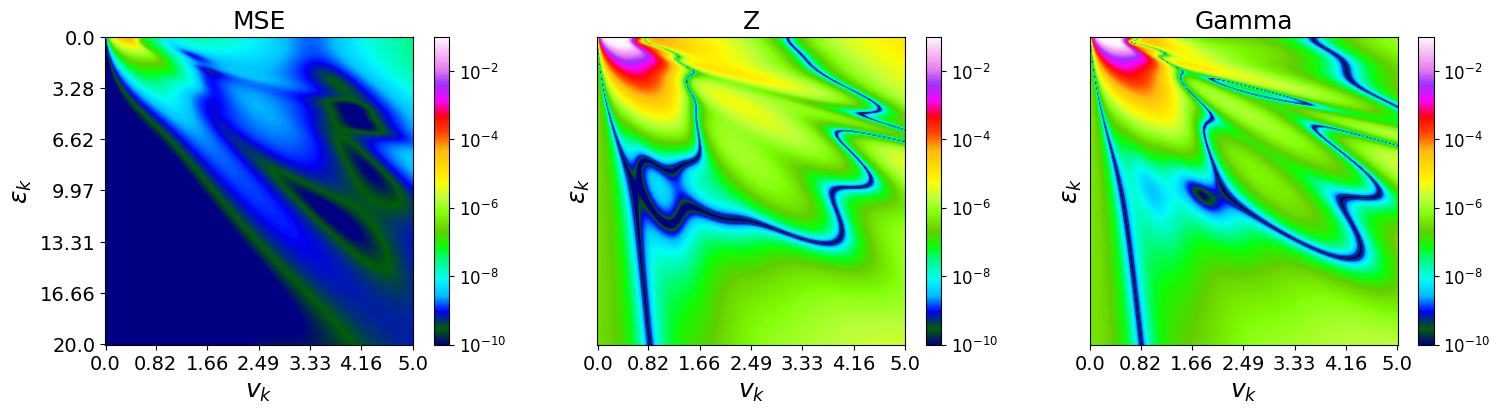

In [42]:
tick_idx = np.linspace(0, 299, 7, dtype=int)
fig, ax = plt.subplots(ncols=3, figsize=(18,4))

fign = 0
pos = ax[fign].imshow(MSE_loss[:,:], interpolation='bilinear', norm=LogNorm(vmin=1e-10, vmax=1e-1), cmap=cm.gist_ncar)
cbar = fig.colorbar(pos, ax=ax[fign])
cbar.ax.tick_params(labelsize=12)
ax[fign].set_title("MSE", fontsize=18)
ax[fign].set_yticks(tick_idx, np.round(sort_ek[tick_idx],2))
ax[fign].set_xticks(tick_idx, np.round(sort_vk[tick_idx],2))
# ax[fign].text(m,n, 'x', color='red', fontsize=14, ha='center', va='center')
ax[fign].set_ylabel(r'$\epsilon_k$', fontsize=18)
ax[fign].set_xlabel(r'$v_k$', fontsize=18)
ax[fign].tick_params(axis='both', labelsize=14)

fign = 1
pos = ax[fign].imshow(Z_loss[:,:], interpolation='bilinear', norm=LogNorm(vmin=1e-10, vmax=1e-1), cmap=cm.gist_ncar)
cbar = fig.colorbar(pos, ax=ax[fign])
cbar.ax.tick_params(labelsize=12)
ax[fign].set_title("Z", fontsize=18)
# ax[fign].set_yticks(tick_idx, np.round(sort_ek[tick_idx],2))
ax[fign].set_yticks([])
ax[fign].set_xticks(tick_idx, np.round(sort_vk[tick_idx],2))
# ax[fign].text(m,n, 'x', color='red', fontsize=14, ha='center', va='center')
ax[fign].set_ylabel(r'$\epsilon_k$', fontsize=18)
ax[fign].set_xlabel(r'$v_k$', fontsize=18)
ax[fign].tick_params(axis='both', labelsize=14)

fign = 2
pos = ax[fign].imshow(gamma_loss[:,:], interpolation='bilinear', norm=LogNorm(vmin=1e-10, vmax=1e-1), cmap=cm.gist_ncar)
cbar = fig.colorbar(pos, ax=ax[fign])
cbar.ax.tick_params(labelsize=12)
ax[fign].set_title("Gamma", fontsize=18)
# ax[fign].set_yticks(tick_idx, np.round(sort_ek[tick_idx],2))
ax[fign].set_yticks([])
ax[fign].set_xticks(tick_idx, np.round(sort_vk[tick_idx],2))
# ax[fign].text(m,n, 'x', color='red', fontsize=14, ha='center', va='center')
ax[fign].set_ylabel(r'$\epsilon_k$', fontsize=18)
ax[fign].set_xlabel(r'$v_k$', fontsize=18)
ax[fign].tick_params(axis='both', labelsize=14)

plt.savefig(f"MSEZG_{fname}.pdf", format='pdf', bbox_inches='tight')


In [43]:
G = data[0,:,:,0,:]
S_target = data[0,:,:,1,:]
S_pred = data[0,:,:,2,:]
S_diff = S_target - S_pred

nn = np.zeros((data.shape[1], data.shape[2]))
nn_pred = np.zeros((data.shape[1], data.shape[2]))
nn_phase = np.zeros((data.shape[1], data.shape[2]))
nn_prox = np.zeros((data.shape[1], data.shape[2]))

full_G = np.zeros(2 * data.shape[4], dtype=complex)
full_S_pred = np.zeros(2 * data.shape[4], dtype=complex)
full_S_target = np.zeros(2 * data.shape[4], dtype=complex)
print(G[0,0].shape)
for e in range(data.shape[1]):
    for v in range(data.shape[2]):
        
        full_G[:data.shape[4]] = np.flip(np.conjugate(1j*G[e,v]))
        full_G[data.shape[4]:] = 1j*G[e,v]
        full_S_target[:data.shape[4]] = np.flip(np.conjugate(1j*S_target[e,v]))
        full_S_target[data.shape[4]:] = 1j*S_target[e,v]
        full_S_pred[:data.shape[4]] = np.flip(np.conjugate(1j*S_pred[e,v]))
        full_S_pred[data.shape[4]:] = 1j*S_pred[e,v]

        nn[e,v] = 0.25 + (full_G @ full_S_target).real / beta
        nn_pred[e,v] = 0.25 + (full_G @ full_S_pred).real / beta

        if nn[e,v] > 0.05:
            nn_phase[e,v] = 1
        if nn[e,v] < 0.05:
            nn_phase[e,v] = -1


for e in range(data.shape[1]):
    p = nn_phase[e,0]
    for v in range(data.shape[2]):
        if p - nn_phase[e,v]!=0:
            v1 = v - 30
            v2 = v +30
            if v1 < 0:
                v1 = 0
            if v2 > 299:
                v2 = 299
            nn_prox[e,v1:v2] = 1
            p = nn_phase[e,v]
        


(1000,)


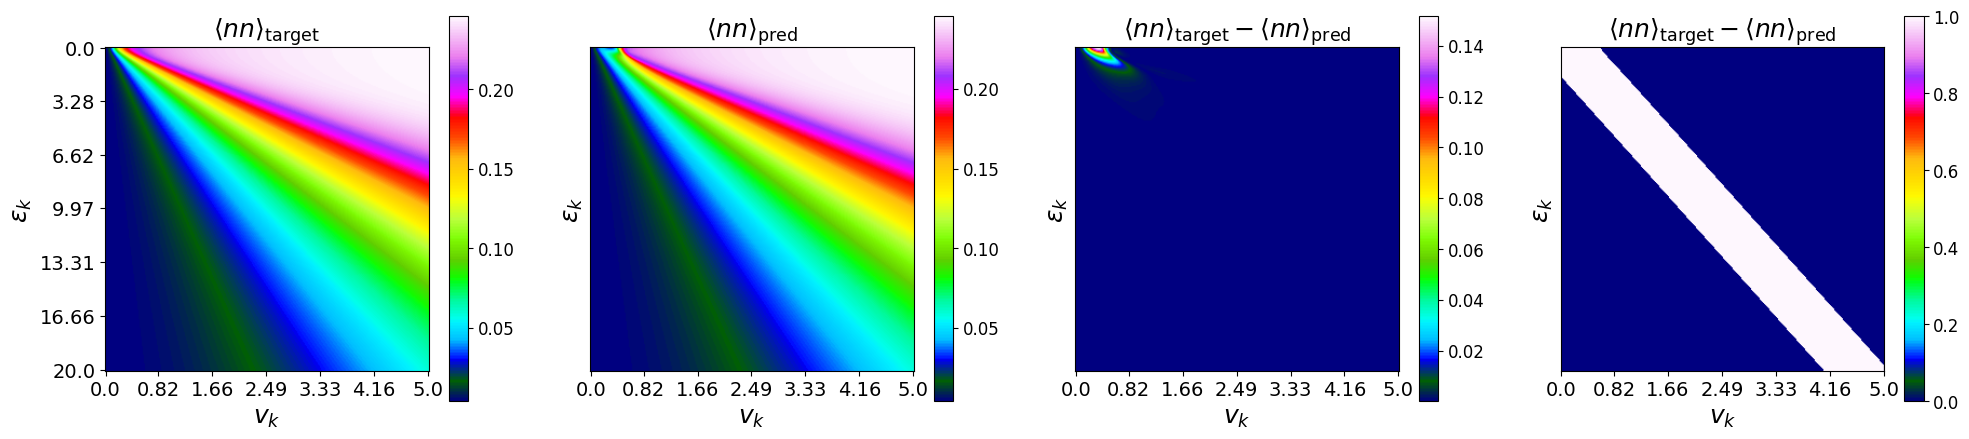

In [44]:
tick_idx = np.linspace(0, 299, 7, dtype=int)
fig, ax = plt.subplots(ncols=4, figsize=(24,5))

fign = 0
pos = ax[fign].imshow(nn[:,:], interpolation='bilinear', cmap=cm.gist_ncar)
cbar = fig.colorbar(pos, ax=ax[fign])
cbar.ax.tick_params(labelsize=12)
ax[fign].set_title(r"$\langle nn \rangle_\text{target}$", fontsize=18)
ax[fign].set_yticks(tick_idx, np.round(sort_ek[tick_idx],2))
ax[fign].set_xticks(tick_idx, np.round(sort_vk[tick_idx],2))
# ax[fign].text(m,n, 'x', color='red', fontsize=14, ha='center', va='center')
ax[fign].set_ylabel(r'$\epsilon_k$', fontsize=18)
ax[fign].set_xlabel(r'$v_k$', fontsize=18)
ax[fign].tick_params(axis='both', labelsize=14)

fign = 1
pos = ax[fign].imshow(nn_pred[:,:], interpolation='bilinear', cmap=cm.gist_ncar)
cbar = fig.colorbar(pos, ax=ax[fign])
cbar.ax.tick_params(labelsize=12)
ax[fign].set_title(r"$\langle nn \rangle_\text{pred}$", fontsize=18)
# ax[fign].set_yticks(tick_idx, np.round(sort_ek[tick_idx],2))
ax[fign].set_yticks([])
ax[fign].set_xticks(tick_idx, np.round(sort_vk[tick_idx],2))
# ax[fign].text(m,n, 'x', color='red', fontsize=14, ha='center', va='center')
ax[fign].set_ylabel(r'$\epsilon_k$', fontsize=18)
ax[fign].set_xlabel(r'$v_k$', fontsize=18)
ax[fign].tick_params(axis='both', labelsize=14)

fign = 2
pos = ax[fign].imshow(abs(nn[:,:] - nn_pred[:,:]), interpolation='bilinear', cmap=cm.gist_ncar)
cbar = fig.colorbar(pos, ax=ax[fign])
cbar.ax.tick_params(labelsize=12)
ax[fign].set_title(r"$\langle nn \rangle_\text{target} - \langle nn \rangle_\text{pred}$", fontsize=18)
# ax[fign].set_yticks(tick_idx, np.round(sort_ek[tick_idx],2))
ax[fign].set_yticks([])
ax[fign].set_xticks(tick_idx, np.round(sort_vk[tick_idx],2))
# ax[fign].text(m,n, 'x', color='red', fontsize=14, ha='center', va='center')
ax[fign].set_ylabel(r'$\epsilon_k$', fontsize=18)
ax[fign].set_xlabel(r'$v_k$', fontsize=18)
ax[fign].tick_params(axis='both', labelsize=14)


fign = 3
pos = ax[fign].imshow(nn_prox[:,:], interpolation='bilinear', cmap=cm.gist_ncar)
cbar = fig.colorbar(pos, ax=ax[fign])
cbar.ax.tick_params(labelsize=12)
ax[fign].set_title(r"$\langle nn \rangle_\text{target} - \langle nn \rangle_\text{pred}$", fontsize=18)
# ax[fign].set_yticks(tick_idx, np.round(sort_ek[tick_idx],2))
ax[fign].set_yticks([])
ax[fign].set_xticks(tick_idx, np.round(sort_vk[tick_idx],2))
# ax[fign].text(m,n, 'x', color='red', fontsize=14, ha='center', va='center')
ax[fign].set_ylabel(r'$\epsilon_k$', fontsize=18)
ax[fign].set_xlabel(r'$v_k$', fontsize=18)
ax[fign].tick_params(axis='both', labelsize=14)


6.822742474916388
4.59866220735786


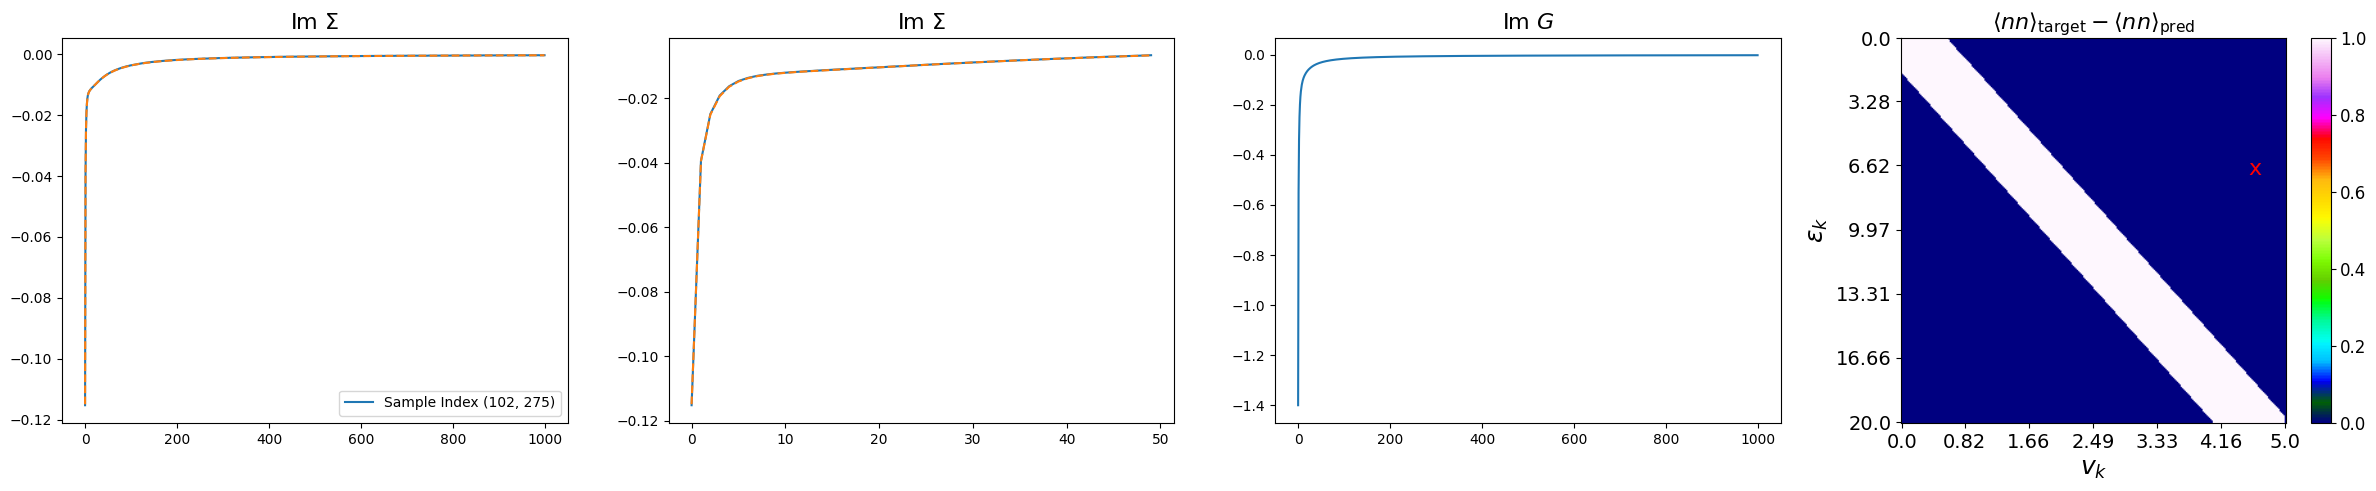

In [45]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=4, figsize=(30,5))

# 35 155
# 40 215
# 61 293
n = 40 #2 
m = 215 # 12
n = int(np.random.rand()*299)
m = int(np.random.rand()*299)

fign = 0
ax[fign].set_title(r"Im $\Sigma$", fontsize=16)
ax[fign].plot(data[0,n,m,2].real, label=f"Sample Index {n,m}")
ax[fign].plot(data[0,n,m,1].real, "--")
ax[fign].legend()

fign = 1
ax[fign].set_title(r"Im $\Sigma$", fontsize=16)
ax[fign].plot(data[0,n,m,2,:50].real, label=f"Sample Index {n,m}")
ax[fign].plot(data[0,n,m,1,:50].real, "--")

fign = 2
ax[fign].plot(data[0,n,m,0].real)
ax[fign].set_title(r"Im $G$", fontsize=16)

print(sort_ek[n])
print(sort_vk[m])

fign = 3
pos = ax[fign].imshow(nn_prox[:,:], interpolation='bilinear', cmap=cm.gist_ncar)
cbar = fig.colorbar(pos, ax=ax[fign])
cbar.ax.tick_params(labelsize=12)
ax[fign].set_title(r"$\langle nn \rangle_\text{target} - \langle nn \rangle_\text{pred}$", fontsize=16)
ax[fign].set_yticks(tick_idx, np.round(sort_ek[tick_idx],2))
# ax[fign].set_yticks([])
ax[fign].set_xticks(tick_idx, np.round(sort_vk[tick_idx],2))
# ax[fign].text(m,n, 'x', color='red', fontsize=14, ha='center', va='center')
ax[fign].set_ylabel(r'$\epsilon_k$', fontsize=18)
ax[fign].set_xlabel(r'$v_k$', fontsize=18)
ax[fign].tick_params(axis='both', labelsize=14)
ax[fign].text(m,n, 'x', color='red', fontsize=16, ha='center', va='center')

x = 0

(300, 300, 1000)


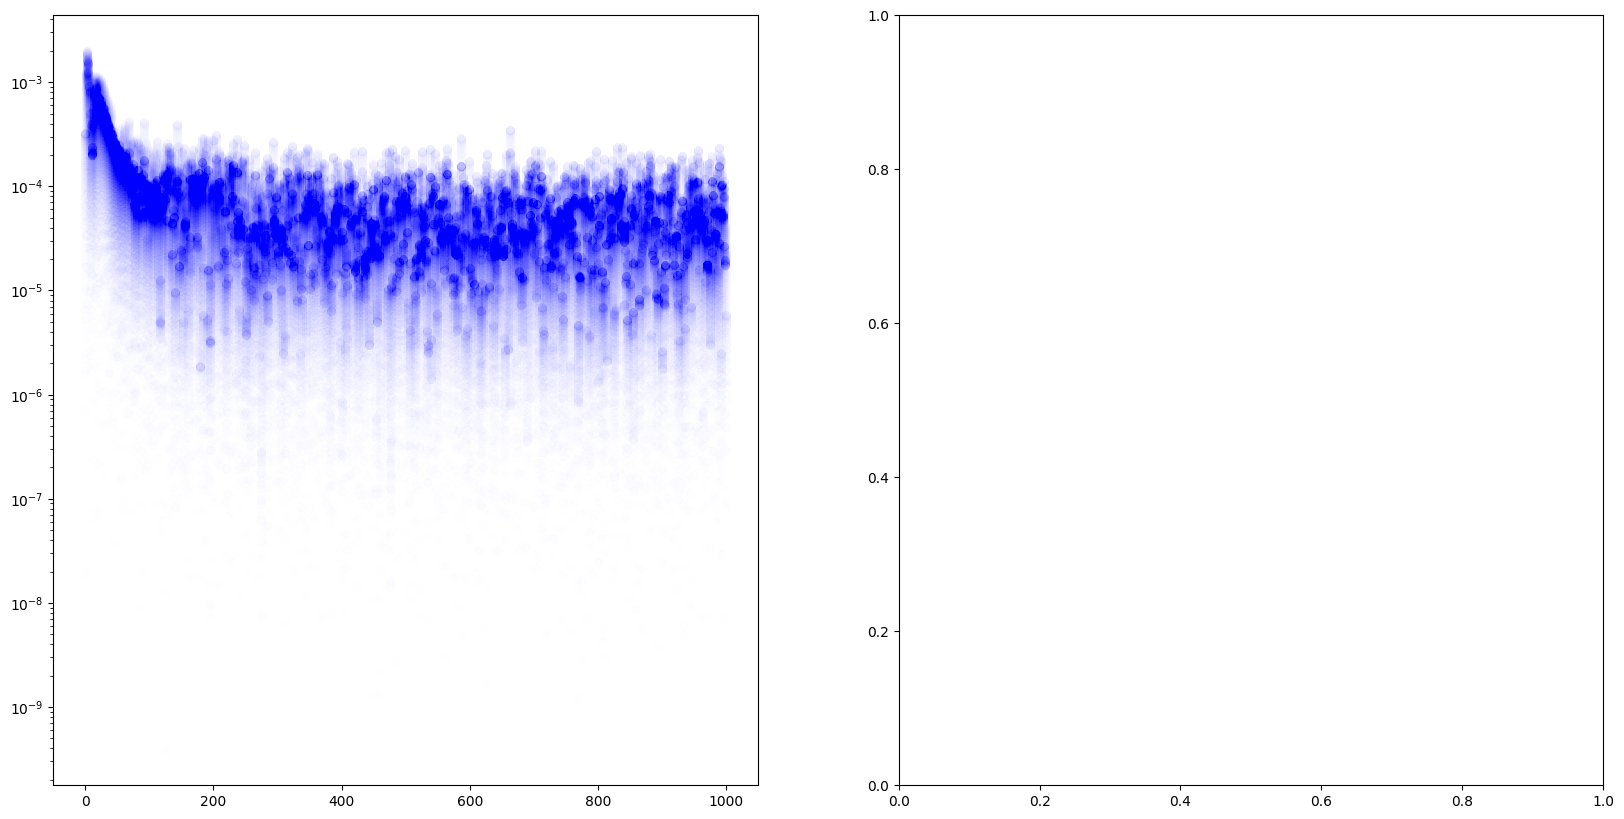

In [48]:
print(S_diff.shape)

S_diff_nu = np.reshape(S_diff, (300*300,1000))

fig, ax = plt.subplots(ncols=2, figsize=(20,10))

fign = 0
# for n in range(300*300):
for n in range(100,300):
    # ax[fign].set_title(r"Im $\Sigma$", fontsize=16)
    ax[fign].plot((abs(S_diff_nu[n,:1000])), "o", color="blue", alpha=0.002, label=f"Sample Index {n,m}")
    ax[fign].set_yscale("log")
    # ax[fign].legend()


In [49]:
hrange = [0,0.0001]
bins = 100
f_Hist = np.zeros((1000,bins))

for v in range(1000):
    f_Hist[v] = np.histogram(abs(S_diff_nu[:,v]), bins=bins, range=hrange)[0]

In [50]:
S_diff_nu.shape
# hrange = [0,0.0005]

# fig, ax = plt.subplots(ncols=2, figsize=(12,6))
# fign = 0
# s1 = ax[fign].hist(abs(S_diff_nu[0,:]), bins=500, range=hrange)
# fign = 1
# s2 = ax[fign].hist(abs(S_diff_nu[10,:]), bins=500, range=hrange)


(90000, 1000)

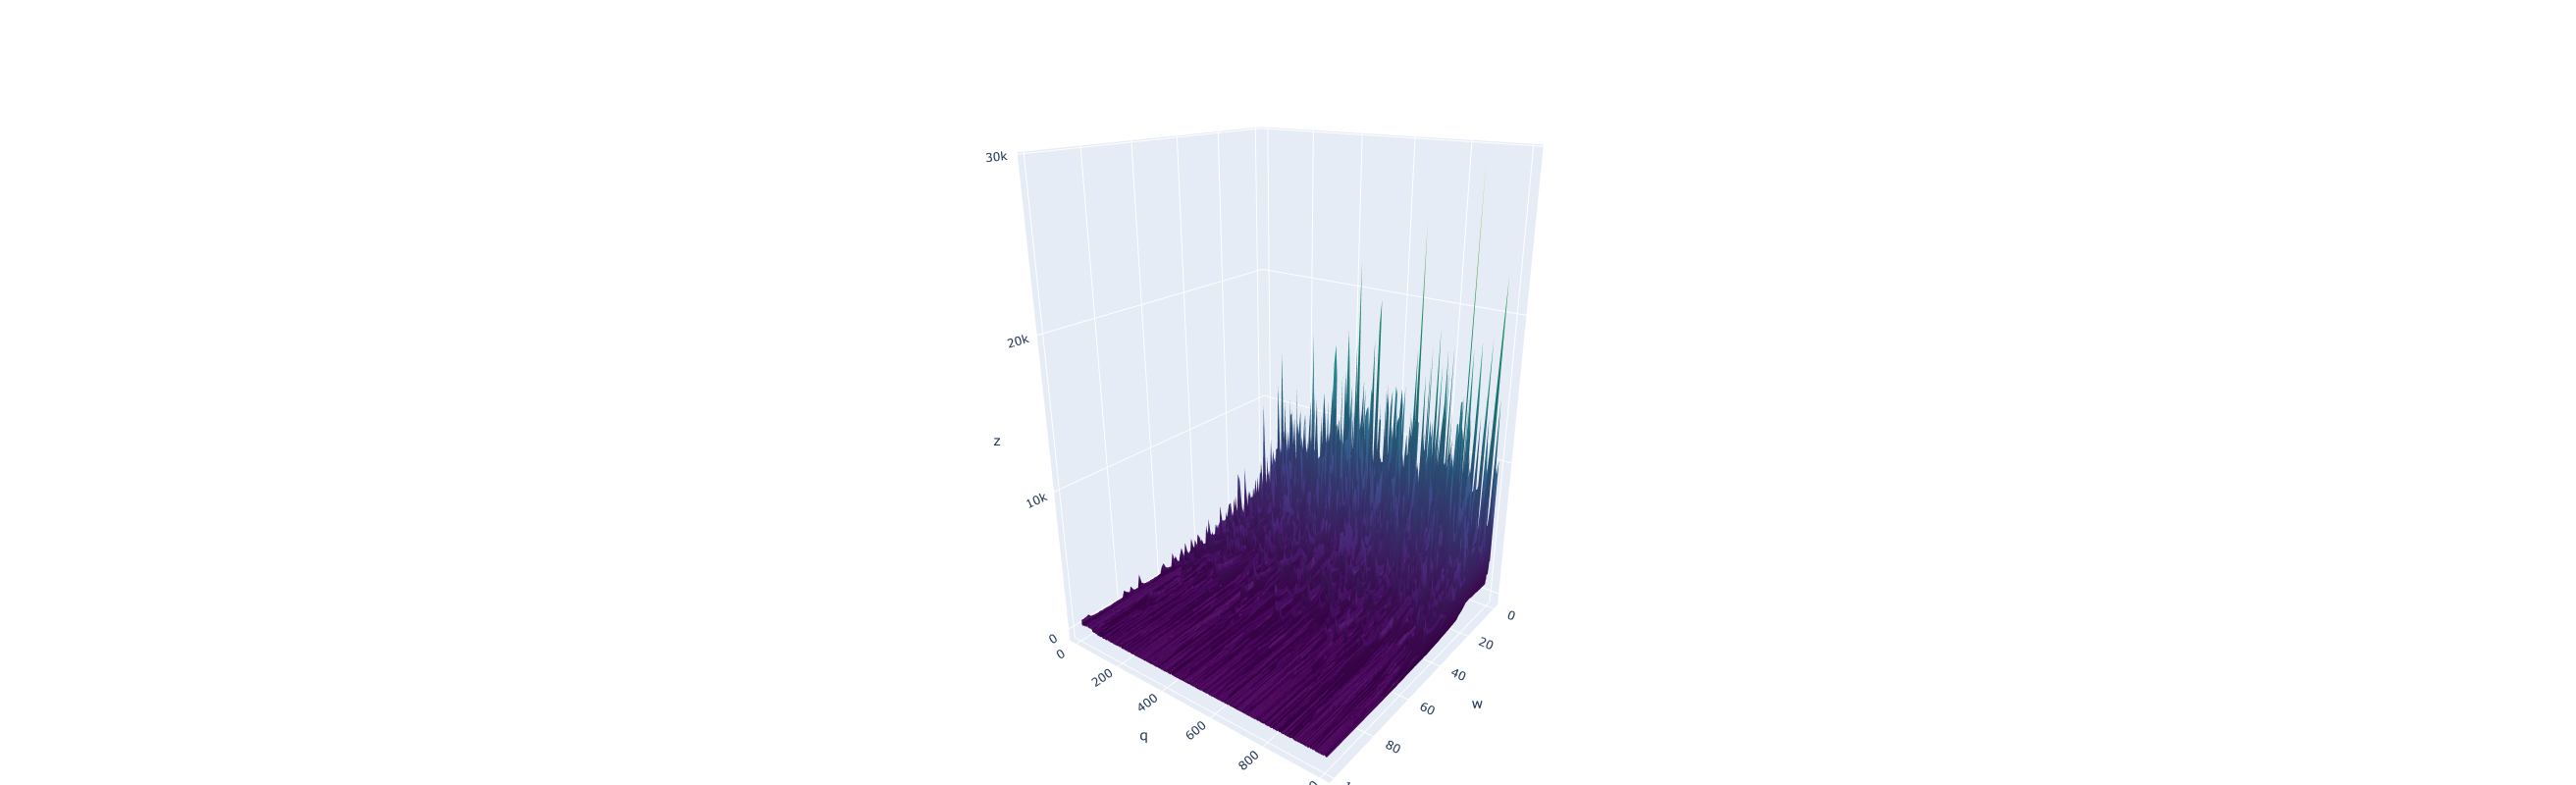

In [51]:
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
# pio.renderers.default = "colab"

fig = make_subplots(
    rows=1, cols=1,
    specs=[[{'type': 'surface'}]],
    subplot_titles=[])# , subplot_titles=(titles))

omega = 1
q = 41

fig.add_trace(
go.Surface(z=f_Hist, colorscale='viridis', showscale=False),
row=1, col=1)

fig.update_scenes(xaxis_title_text='w',  
                  yaxis_title_text='q')

camera = dict(
    eye=dict(x=2, y=1.5, z=1.)
)
aspectratio = dict(x=1, y=1., z=1.5)

    
fig.layout.scene1.camera = camera
fig.layout.scene1.aspectratio=aspectratio

fig.update_layout(
    scene1 = dict(zaxis = dict(nticks=4),),
    title=r'',
    autosize=True,
    width=1000, height=800,
    margin=dict(l=10, r=5, b=0, t=35))

fig.show()

In [52]:
fname = f"GNN_1_trainbase_BS1_2025-06-22_v3_ST.h5"
beta = 10
PATH = fname
with h5py.File(PATH, "r") as f:
    sort_ek = f["ek"][:]
    sort_vk = f["vk"][:]
    data = f["data"][:]
    gamma_loss = f["gamma_loss"][:]
    Z_loss = f["Z_loss"][:]
    MSE_loss = f["MSE_loss"][:]
S_target = data[0,:,:,1,:]
S_pred = data[0,:,:,2,:]
S_diff = S_target - S_pred
S_diff_nu1 = np.reshape(S_diff, (300*300,1000))
data1 = data

fname1 = f"GNN_1_trainbase_BS1_2025-06-29_v2_ST.h5"
PATH = fname1
with h5py.File(PATH, "r") as f:
    sort_ek = f["ek"][:]
    sort_vk = f["vk"][:]
    data = f["data"][:]
    gamma_loss = f["gamma_loss"][:]
    Z_loss = f["Z_loss"][:]
    MSE_loss = f["MSE_loss"][:]
S_target = data[0,:,:,1,:]
S_pred = data[0,:,:,2,:]
S_diff = S_target - S_pred
S_diff_nu2 = np.reshape(S_diff, (300*300,1000))
data2 = data

In [53]:
mu_i = np.zeros((1000,2))
std_i = np.zeros((1000,2))
for v in range(1000):
    mu_i[v,0] = np.mean(S_diff_nu1[:,v].real)
    std_i[v,0] = np.std(S_diff_nu1[:,v].real)
    mu_i[v,1] = np.mean(S_diff_nu2[:,v].real)
    std_i[v,1] = np.std(S_diff_nu2[:,v].real)

In [96]:
x = np.linspace(-2e-4,2e-4,1001)
G_full = np.zeros((2,1000,1001))
for v in range(1000):
    G_full[0,v,:] = np.exp(-1/std_i[v,0]**2 * (x - mu_i[v,0])**2)
    G_full[1,v,:] = np.exp(-1/std_i[v,1]**2 * (x - mu_i[v,1])**2)

[[ 1.50322901e-03  2.47478378e-04]
 [ 7.85318723e-05 -2.56286637e-04]
 [-1.52914162e-04 -2.42730506e-04]
 ...
 [-9.96061435e-06  2.08739221e-05]
 [-5.73958067e-06 -5.96375651e-06]
 [ 3.49008746e-06  7.87244513e-06]]


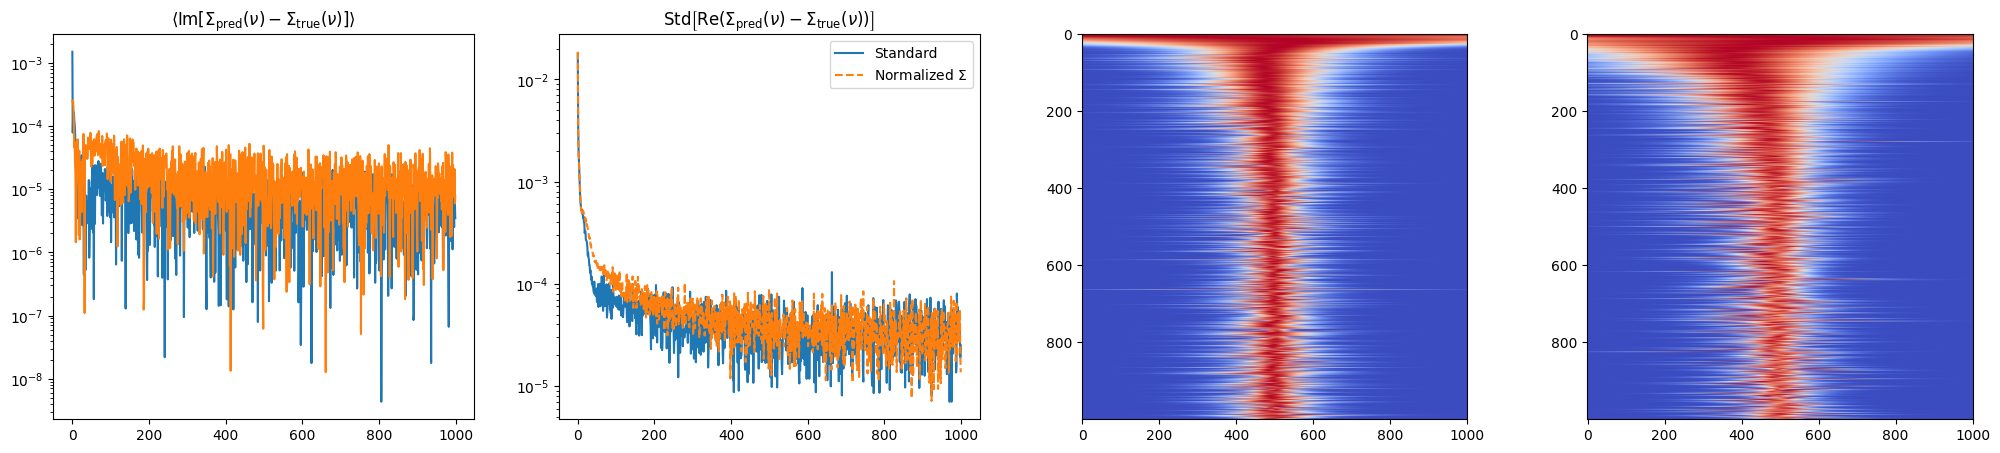

In [101]:
fig, ax = plt.subplots(ncols=4, figsize=(25,5))
ax[0].plot(abs(mu_i[:,0]))
ax[0].plot(abs(mu_i[:,1]))
ax[0].set_yscale("log")
# ax[0].legend()
ax[0].set_title(r"$\langle \mathrm{Im}[\Sigma_{\mathrm{pred}}(\nu) - \Sigma_{\mathrm{true}}(\nu)] \rangle$")
ax[1].plot(std_i[:,0], label="Standard")
ax[1].plot(std_i[:,1], "--", label=r'Normalized $\Sigma$')
ax[1].set_yscale("log")
ax[1].set_title(r"$\mathrm{Std}\left[\mathrm{Re}(\Sigma_{\mathrm{pred}}(\nu) - \Sigma_{\mathrm{true}}(\nu))\right]$")
ax[1].legend()

ax[2].imshow(G_full[0], cmap="coolwarm")
ax[3].imshow(G_full[1], cmap="coolwarm")

plt.savefig(f"mu_std_{fname}_{fname1}.pdf", format='pdf', bbox_inches='tight')

6 34
0.4013377926421405
0.568561872909699


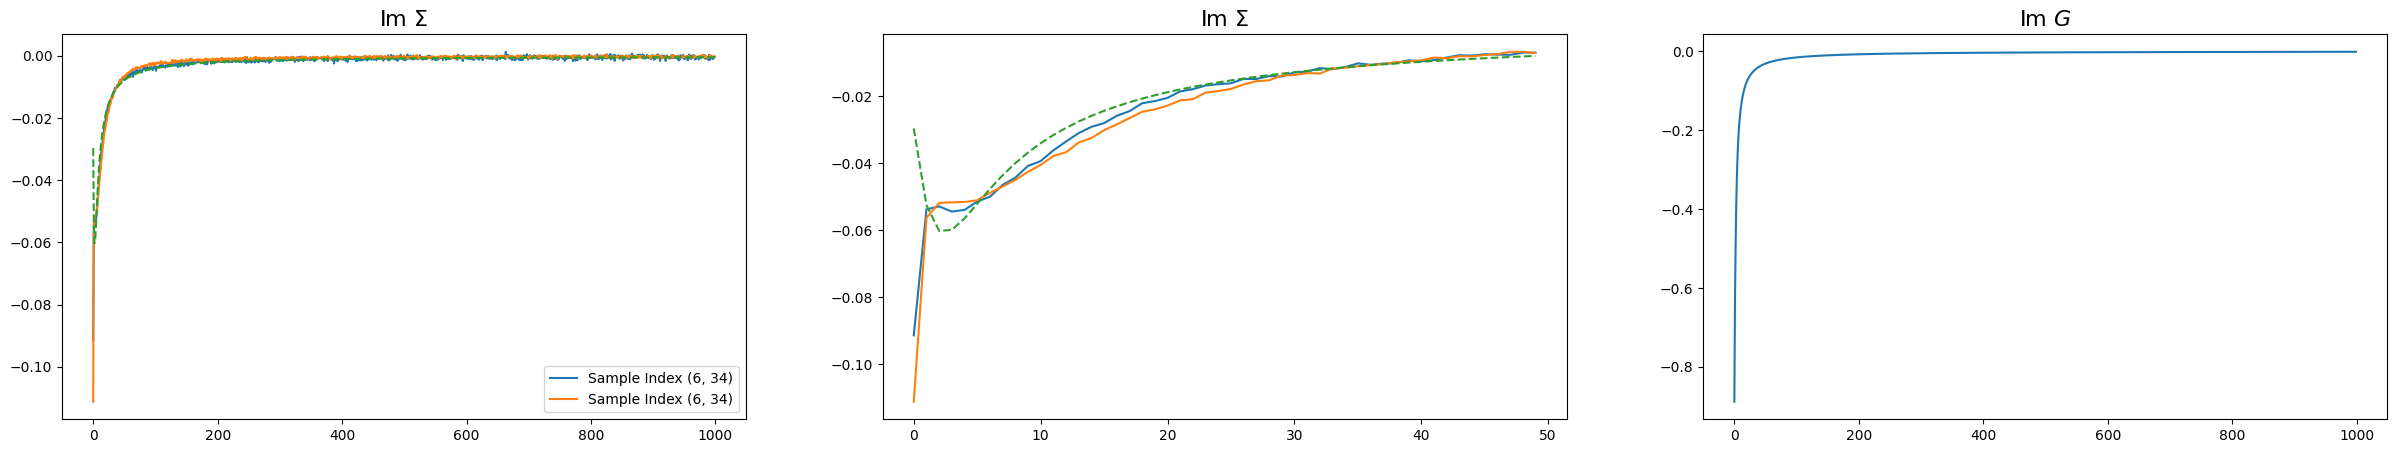

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=3, figsize=(30,5))

# 35 155
# 40 215
# 61 293
n = 40 # 40 2 6
m = 215 # 215 12 34
n = int(np.random.rand()*299)
m = int(np.random.rand()*299)
print(n,m)


fign = 0
ax[fign].set_title(r"Im $\Sigma$", fontsize=16)
ax[fign].plot(data1[0,n,m,2].real, label=f"Sample Index {n,m}")
ax[fign].plot(data2[0,n,m,2].real, label=f"Sample Index {n,m}")
ax[fign].plot(data1[0,n,m,1].real, "--")
ax[fign].legend()

fign = 1
ax[fign].set_title(r"Im $\Sigma$", fontsize=16)
ax[fign].plot(data1[0,n,m,2,:50].real, label=f"Sample Index {n,m}")
ax[fign].plot(data2[0,n,m,2,:50].real, label=f"Sample Index {n,m}")
ax[fign].plot(data1[0,n,m,1,:50].real, "--")

fign = 2
# ax[fign].plot(data1[0,n,m,0].real)
# ax[fign].set_title(r"Im $G$", fontsize=16)

print(sort_ek[n])
print(sort_vk[m])


x = 0